<a href="https://colab.research.google.com/github/yongtaoliu/Ferroelectric-wall-dynamics-and-pinning-mechanisms/blob/main/Ferroelectric_DW_dynamics_Notebook3_Identification_of_pinning_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification of pinning mechanism**

May, 2021

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- PZT IDS-PFM data by [Roger Proksch](https://scholar.google.com/citations?hl=en&user=8OjHap0AAAAJ&view_op)
- rVAE realized via atomai by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- Detailed analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

Package Version:


*   atomai: 0.6.6
*   numpy: 1.19.5
*   matplotlib: 3.2.2
*   cv2: 4.1.2
*   skimage: 0.16.2
*   scipy: 1.4.1

In [ ]:
#@title Install AtomAI
!pip install atomai==0.6.6

In [ ]:
#@title Import
import numpy as np
import matplotlib.pyplot as plt
import cv2
import atomai as aoi
from atomai.utils import extract_patches_ 
from skimage import feature
from scipy.ndimage.filters import gaussian_filter
from atomai import utils
from scipy import ndimage
from scipy.stats import norm

In [ ]:
#@title Download Data
!gdown https://drive.google.com/uc?id=1CTKMiud-KnRPzBe__UAfNZB4pE8rkG1h   #download phase images
!gdown https://drive.google.com/uc?id=1HGI6qZAqmYeeNZTewJot1q_AH06-ppkt   #download amplitude images
!gdown https://drive.google.com/uc?id=1M6VqMfJMyutusKSzhFPBd7vBva_2Azxm   #download 180&non180 wall images generated by DCNN network

Downloading...
From: https://drive.google.com/uc?id=1CTKMiud-KnRPzBe__UAfNZB4pE8rkG1h
To: /content/test_imgs2_phase.npy
133MB [00:00, 235MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HGI6qZAqmYeeNZTewJot1q_AH06-ppkt
To: /content/test_imgs2.npy
133MB [00:00, 153MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1M6VqMfJMyutusKSzhFPBd7vBva_2Azxm
To: /content/TrainedData_TestImages2.npy
133MB [00:00, 216MB/s]


### Load Data

In [ ]:
pha_imgs = np.load('test_imgs2_phase.npy')           #load phase images
amp_imgs = np.load('test_imgs2.npy')                #load amplitude image
amp_wall_ = np.load('TrainedData_TestImages2.npy')   #load 180&non180 wall images generated by DCNN from amplitude images 

### Generate 180 Wall Images

In [ ]:
#deonise phase images first
pha_imgs_g = gaussian_filter(pha_imgs, sigma = 1.0)   

#predict 180 walls in phase images by Canny filter 
pha_wall_ = np.zeros_like(pha_imgs_g) #initializ an array for saving 180 wall images
for i in range (39):
    pha_wall_[i,...] = feature.canny(pha_imgs_g[i,...], sigma=3.0)

### Prepare data for VAE analysis

In [ ]:
# cut edges due to the boundary lines in images and remove first two frames due to high noise
pha_wall = pha_wall_[2:,5:-5,5:-5]
amp_wall = amp_wall_[2:,5:-5,5:-5]
pha = pha_imgs[2:,5:-5,5:-5]
amp = amp_imgs[2:,5:-5,5:-5]

Show representative walls

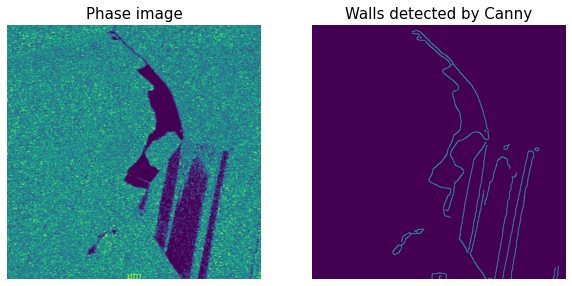

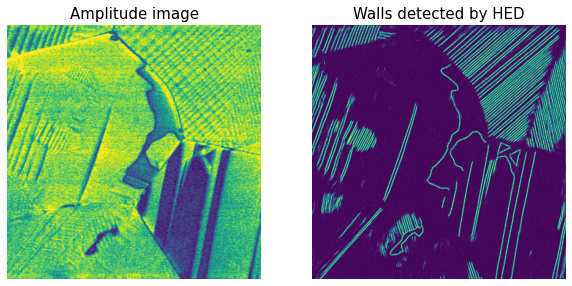

In [ ]:
i = 33  #set the frame number to look

#plot phase and 180 wall images
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(pha[i,...])
ax1.axis('off')
ax1.set_title('Phase image', fontsize = 15)
ax2.imshow(pha_wall[i,...])
ax2.axis('off')
ax2.set_title('Walls detected by Canny', fontsize = 15)
plt.show()

#plot amplitude and 180&non180 wall images
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(amp[i,...])
ax1.axis('off')
ax1.set_title('Amplitude image', fontsize = 15)
ax2.imshow(amp_wall[i,...])
ax2.axis('off')
ax2.set_title('Walls detected by HED', fontsize = 15)
plt.show()

### Prepare non180 wall images by subtraction
*   non180 wall is obtained by: sub_wall = amp_wall - pha_wall




(-0.5, 641.5, 641.5, -0.5)

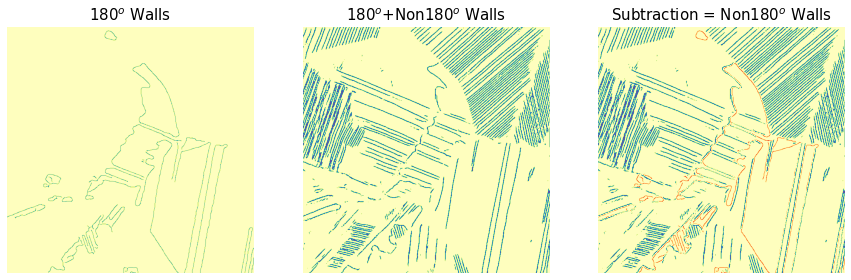

In [ ]:
#prepare binary wall images first
for i in range (37): 
  ret,pha_wall[i,...] = cv2.threshold(pha_wall[i,...],0.5,1,cv2.THRESH_BINARY)
  ret,amp_wall[i,...] = cv2.threshold(amp_wall[i,...],0.5,1,cv2.THRESH_BINARY)

#subtract 180-wall images from 180&non180-wall image to make non180-wall images
sub_wall = np.subtract(amp_wall, pha_wall)

#show a set of representative images
i = 15   #set the frame number to look
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.imshow(pha_wall[i,...], vmin =-1, vmax = 1, cmap = 'Spectral')
ax1.set_title('180$^o$ Walls', fontsize = 15)
ax1.axis('off')
ax2.imshow(amp_wall[i,...], vmin =-1, vmax = 1, cmap = 'Spectral')
ax2.set_title('180$^o$+Non180$^o$ Walls', fontsize = 15)
ax2.axis('off')
ax3.imshow(sub_wall[i,...], vmin =-1, vmax = 1, cmap = 'Spectral')
ax3.set_title('Subtraction = Non180$^o$ Walls', fontsize = 15)
ax3.axis('off')

### Prepare three-layer dataset 

*   The three-layer dataset is prepared by stacking 180-wall, non180-wall, non180-wall images

(-0.5, 641.5, 641.5, -0.5)

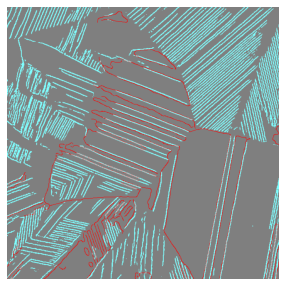

In [ ]:
#initialize an array for saving three-layer data
imgstack = np.zeros((37,642,642,3))

#stack three layer
for i in range (37):
  imgstack[i,...]=np.dstack((pha_wall[i,...], sub_wall[i,...], sub_wall[i,...]))

#normalize the three-layer dataset
imgstack = (imgstack-imgstack.min())/(imgstack.max()-imgstack.min())

#show a representative image of the three-layer dataset
f,ax = plt.subplots(figsize = (5,5))
ax.imshow(imgstack[1,...], vmin =0, vmax = 1, cmap = 'bwr')
ax.axis('off')

# rVAE training preparation

### Prepare wall coordinate dataset for extracting sub-images

Two coordinate datasets will be prepared:


*   First coordinate set without time delay
*   Second coordinate set with time delay
*   Both coordinate sets are 180 wall coordinates




In [ ]:
#first coordinate set without time delay
wi = imgstack

wall_cor = ()

for i in range (37):
  index = np.where(wi[i,...] == 0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

dictionary = {}
for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*3,])):
    d = np.append(d,[[cor[j*3][i]], [cor[j*3+1][i]], [0]], axis =1)

  d=d.T
  #control coordinates size to 100
  A = np.arange(len(d))
  idx = np.random.choice(A, 100, replace = False)
  B = d[idx,]
  dictionary [j] = np.array(B)

coordinates_180 = dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Second coordinate set with time delay t vs t+1
wi = imgstack

dictionary = {}

wall_cor = ()
for i in range (37):
  index = np.where(wi[i,...]==0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*3,])):
    d = np.append(d,[[cor[j*3][i]], [cor[j*3+1][i]], [0]], axis =1)
  d=d.T
  #control coordinates size to 100
  A = np.arange(len(d))
  idx = np.random.choice(A, 100, replace = False)
  B = d[idx,]
  dictionary [j*2] = np.array(B)
  dictionary [j*2+1] = np.array(B)

coordinates_180_t = dictionary
coordinates_180_t.pop(73);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


### Prepare three-layer image dataset for time dynamics (t vs t+1) analysis

In [ ]:
#intialize a dataset for saving time delay images
imgstack_t = np.zeros_like(imgstack)
imgstack_t = np.append(imgstack_t,imgstack_t[:-1,...], axis = 0)
imgstack_t[0,...]= imgstack[0,...]

#save images into imgstack_t
for i in range (1,37):
  imgstack_t[i*2]=imgstack[i]
  imgstack_t[i*2-1]=imgstack[i]   

# rVAE Train



*   training process is provided below
*   trained weights are also provided after training cells for readers, so readers can easily explore the results by loading trained weights




rVAE trains for the dataset without time delay

In [ ]:
window_sizes = [10, 20, 30, 60, 90, 120]  #customsize window size of subimages

for ws in window_sizes:
  imstack, com, frames = utils.extract_subimages(imgstack, coordinates_180, ws)     #extract subimages

  in_dim = (ws,ws,3)    # define dimension
  rvae = aoi.models.rVAE(in_dim, translation = False)    #initialize rvae model
  rvae.fit(imstack, training_cycles=500)           #train
  print('\n')

rVAE trains for the dataset with time delay

In [ ]:
window_sizes = [10, 20, 30, 60, 90, 120]    #Define window size of subimages

for ws in window_sizes:
  imstack, com, frames = utils.extract_subimages(imgstack_t, coordinates_180_t, ws)     #extract subimages

  in_dim = (ws,ws,3) #
  rvae = aoi.models.rVAE(in_dim, translation = False)  #initialize rvae model
  rvae.fit(imstack, training_cycles=500)  #train
  print('\n')

# Load trained wieght and do analysis

In [ ]:
#@title Download trained weights
# trained weights for three-layer dataset with time delay
!gdown https://drive.google.com/uc?id=1_eEH024tz1rWqh0x9t49dZxj_SUJKDdB
!gdown https://drive.google.com/uc?id=1--4KgHDfwV3tKzA80Bp4fTtHNM4DDOAu
!gdown https://drive.google.com/uc?id=1MGEJk_JUQesApp1a9nlB3KbLIUcOR9sZ
!gdown https://drive.google.com/uc?id=1--UBId-UN1KpAfcaDObtMc--R9b-yljs
!gdown https://drive.google.com/uc?id=1-21nqFZacM4ydZ8foppmkuA4jf9zWdnR
!gdown https://drive.google.com/uc?id=1-AmGNY3rik0psho18ACsTK_ZsiU2CWSj

# trained weights for three-layer dataset with time delay
!gdown https://drive.google.com/uc?id=1-0_GglAxVJHbF9uot_x2APL5SqzBTJ2A
!gdown https://drive.google.com/uc?id=1-0t1Np8my-0_PRjtOy7RwUCGwpyK_eMC
!gdown https://drive.google.com/uc?id=1-CbuA6Ff44aC71mF9f6kcfxkDH2Jc030
!gdown https://drive.google.com/uc?id=1-CcHdllkwIHjCxCPLNvoEFCeQTnMkt7Q
!gdown https://drive.google.com/uc?id=1-Fu4tTnb8wlVv7Gj3uZc68A0zQ1WOdD6
!gdown https://drive.google.com/uc?id=1-JAS03gmBdH3QDTCblyPWXiBQSrrit9r

Downloading...
From: https://drive.google.com/uc?id=1_eEH024tz1rWqh0x9t49dZxj_SUJKDdB
To: /content/rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws10.tar
100% 1.10M/1.10M [00:00<00:00, 73.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--4KgHDfwV3tKzA80Bp4fTtHNM4DDOAu
To: /content/rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws20.tar
2.48MB [00:00, 79.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MGEJk_JUQesApp1a9nlB3KbLIUcOR9sZ
To: /content/rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws30.tar
4.78MB [00:00, 74.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--UBId-UN1KpAfcaDObtMc--R9b-yljs
To: /content/rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws60.tar
17.2MB [00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-21nqFZacM4ydZ8foppmkuA4jf9zWdnR
To: /content/rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws90.tar
38.0M

Load trained models
- rvae_models: models without time delay
- rvae_models_t: models with time delay

In [ ]:
#Load trained weights
rvae_10 = aoi.models.rVAE(in_dim = (10,10,3), translation = False)
rvae_10.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws10.tar")
rvae_20 = aoi.models.rVAE(in_dim = (20,20,3), translation = False)
rvae_20.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws20.tar")
rvae_30 = aoi.models.rVAE(in_dim = (30,30,3), translation = False)
rvae_30.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws30.tar")
rvae_60 = aoi.models.rVAE(in_dim = (60,60,3), translation = False)
rvae_60.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws60.tar")
rvae_90 = aoi.models.rVAE(in_dim = (90,90,3), translation = False)
rvae_90.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws90.tar")
rvae_120 = aoi.models.rVAE(in_dim = (120,120,3), translation = False)
rvae_120.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_ws120.tar")

rvae_10_t = aoi.models.rVAE(in_dim = (10,10,3), translation = False)
rvae_10_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws10.tar")
rvae_20_t = aoi.models.rVAE(in_dim = (20,20,3), translation = False)
rvae_20_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws20.tar")
rvae_30_t = aoi.models.rVAE(in_dim = (30,30,3), translation = False)
rvae_30_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws30.tar")
rvae_60_t = aoi.models.rVAE(in_dim = (60,60,3), translation = False)
rvae_60_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws60.tar")
rvae_90_t = aoi.models.rVAE(in_dim = (90,90,3), translation = False)
rvae_90_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws90.tar")
rvae_120_t = aoi.models.rVAE(in_dim = (120,120,3), translation = False)
rvae_120_t.load_weights("rVAE_DW@180&non180center_stack3layer180non180non180_noresize_tran=F_tvst+1_ws120.tar")

rvae_models = [rvae_10, rvae_20, rvae_30, rvae_60, rvae_90, rvae_120]
rvae_models_t = [rvae_10_t, rvae_20_t, rvae_30_t, rvae_60_t, rvae_90_t, rvae_120_t]

### Plot latent variables distribtuion

*  Plots of rVAE models without time delay

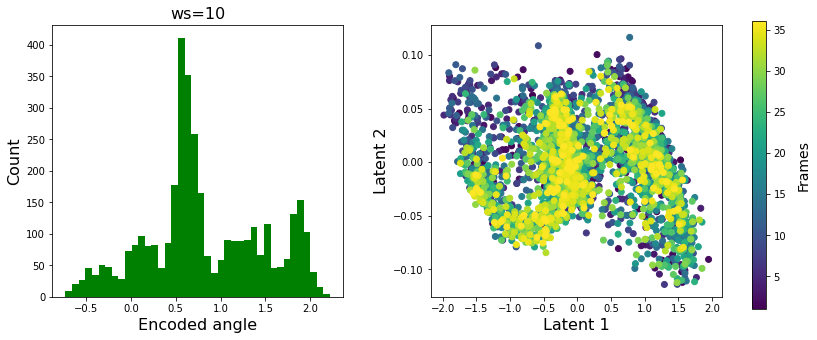

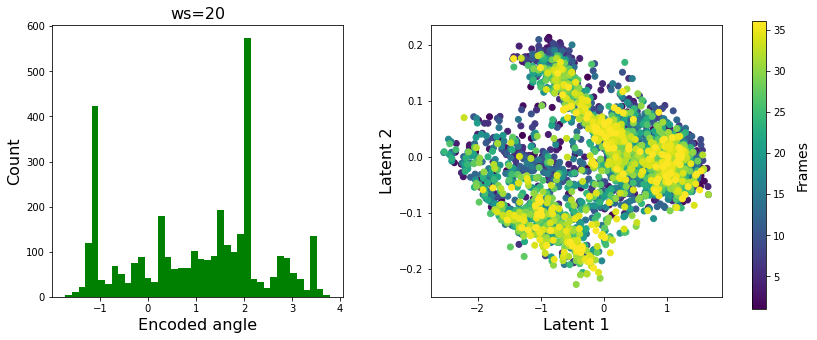

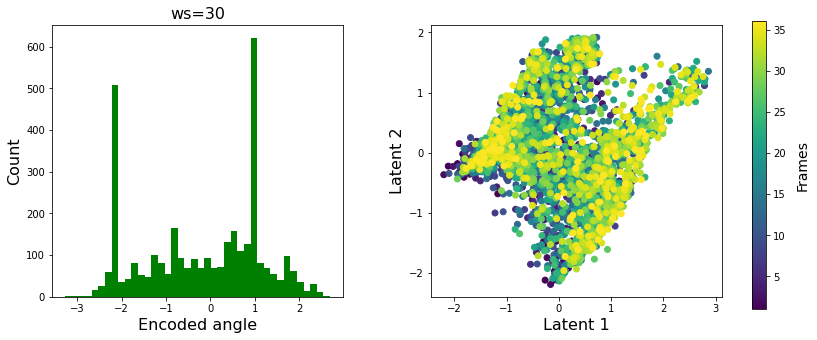

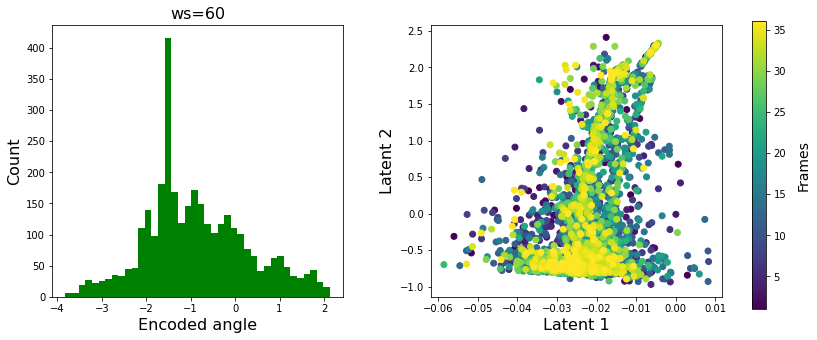

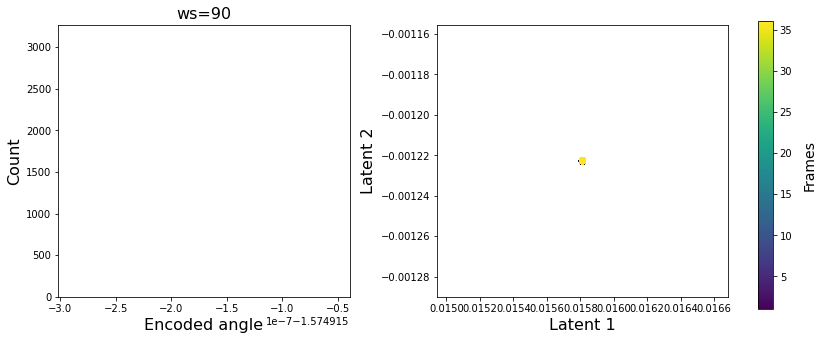

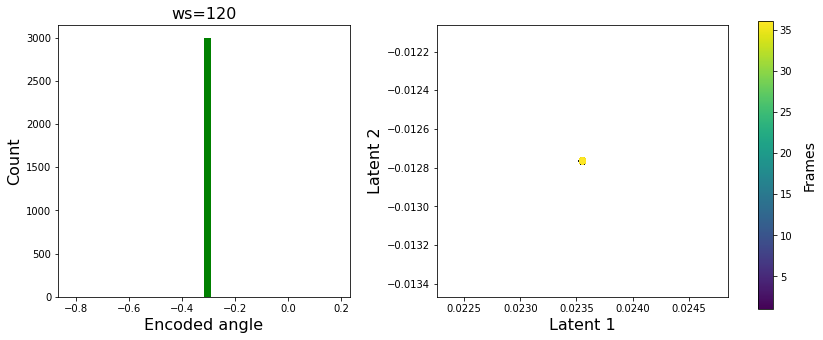

In [ ]:
imgdata = imgstack
window_sizes = [10, 20, 30, 60, 90, 120]

for rvae_, ws in zip(rvae_models, window_sizes):
    # Generate stack of images with given window size
    imstack, com, frames = utils.extract_subimages(imgdata, coordinates_180, ws)
    # Encode the generated image stack
    z_mean, _ = rvae_.encode(imstack)
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.hist(z_mean[:, 0], bins=40, color="green")
    ax1.set_xlabel("Encoded angle", fontsize=16)
    ax1.set_ylabel("Count", fontsize=16)
    ax1.set_title('ws='+str(ws), fontsize=16)

    ax2.scatter(z_mean[:, 1], z_mean[:, 2], c = frames)
    ax2.set_xlabel("Latent 1", fontsize=16)
    ax2.set_ylabel("Latent 2", fontsize=16)

    clrbar = np.linspace(1, np.max(frames)).reshape(-1, 1)
    ax_ = fig.add_axes([.68, .09, .30, .80])
    img = plt.imshow(clrbar)
    plt.gca().set_visible(False)
    clrbar = plt.colorbar(img, ax=ax_, orientation='vertical')
    clrbar.set_label('Frames', fontsize=14, labelpad=10)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

*  Plots of rVAE models without time delay

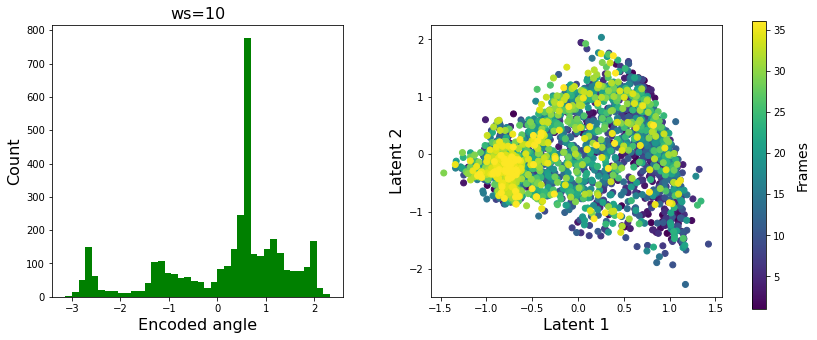

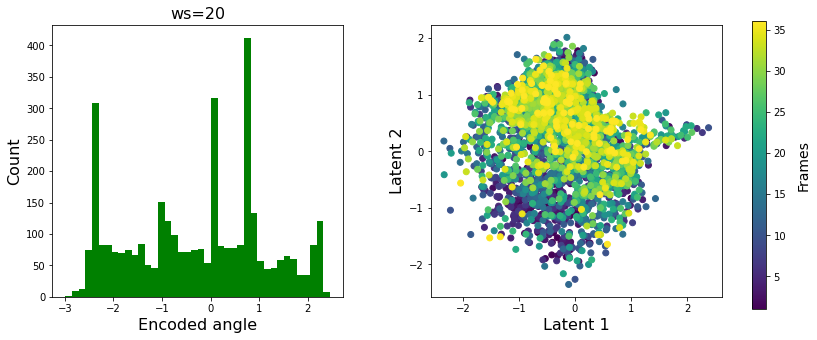

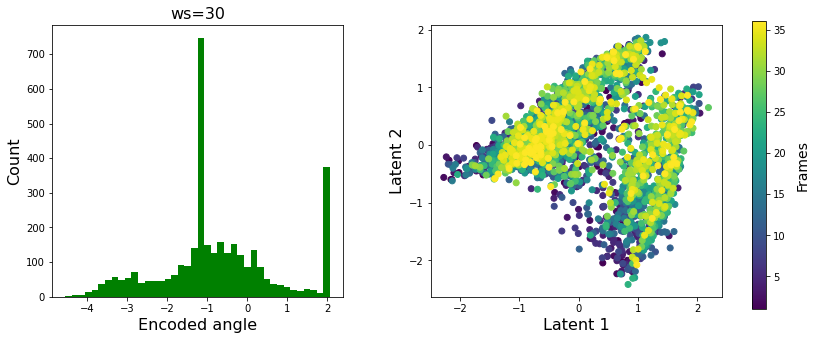

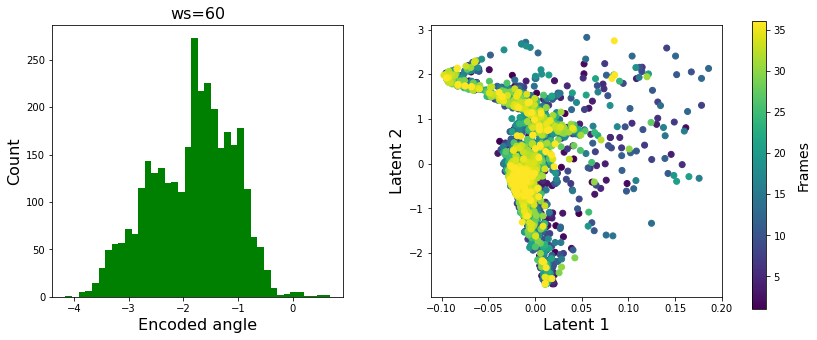

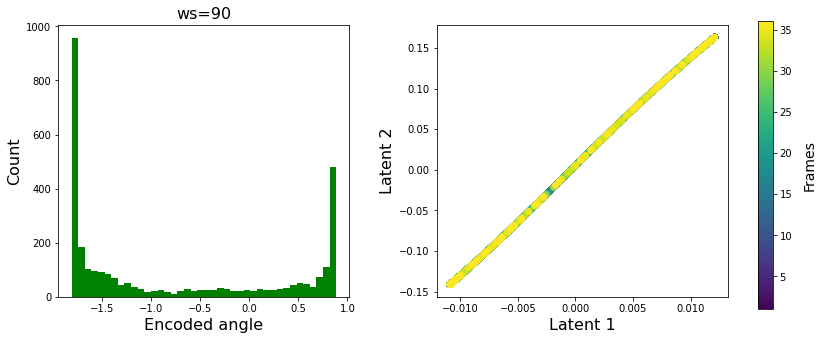

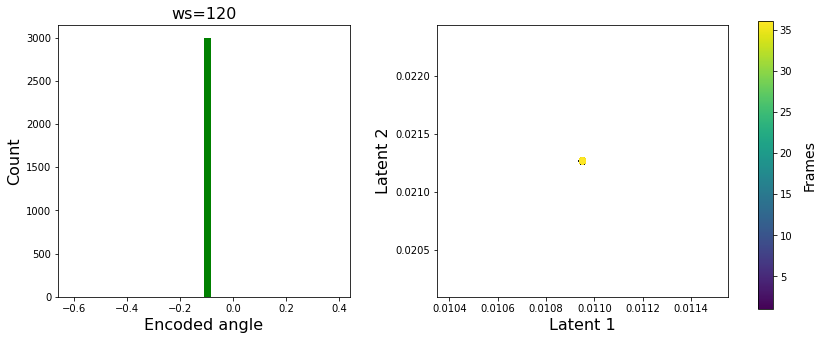

In [ ]:
imgdata = imgstack_t 
window_sizes = [10, 20, 30, 60, 90, 120]

for rvae_, ws in zip(rvae_models_t, window_sizes):
    # # Generate stack of images with given window size
    imstack, com, frames = utils.extract_subimages(imgdata, coordinates_180, ws)
    # Encode the generated image stack
    z_mean, _ = rvae_.encode(imstack)
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(z_mean[:, 0], bins=40, color="green")
    ax1.set_xlabel("Encoded angle", fontsize=16)
    ax1.set_ylabel("Count", fontsize=16)
    ax1.set_title('ws='+str(ws), fontsize=16)

    ax2.scatter(z_mean[:, 1], z_mean[:, 2], c = frames)
    ax2.set_xlabel("Latent 1", fontsize=16)
    ax2.set_ylabel("Latent 2", fontsize=16)

    clrbar = np.linspace(1, np.max(frames)).reshape(-1, 1)
    ax_ = fig.add_axes([.68, .09, .30, .80])
    img = plt.imshow(clrbar)
    plt.gca().set_visible(False)
    clrbar = plt.colorbar(img, ax=ax_, orientation='vertical')
    clrbar.set_label('Frames', fontsize=14, labelpad=10)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

### Plot manifold2D

*  Manifold2D of rVAE models without time delay

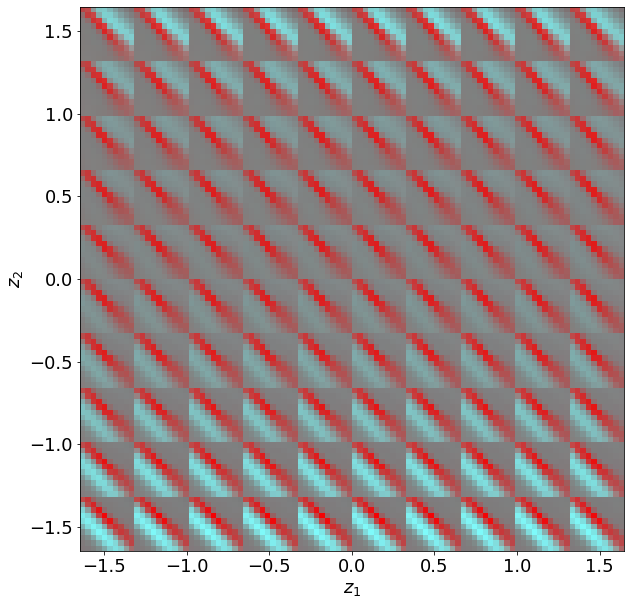

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


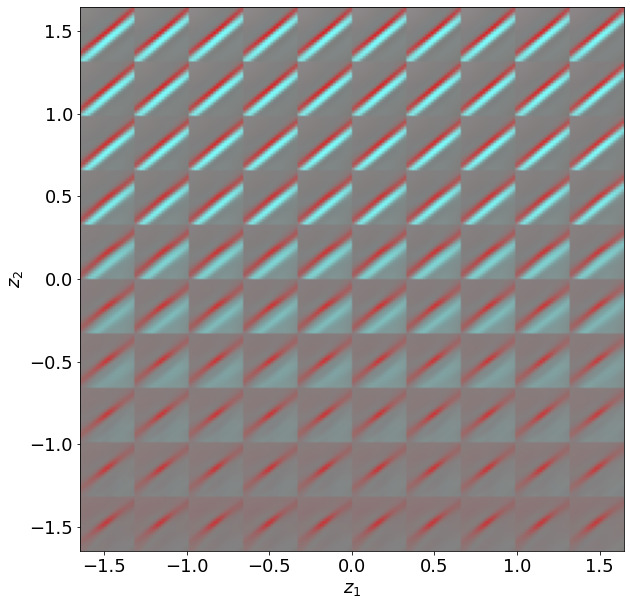

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


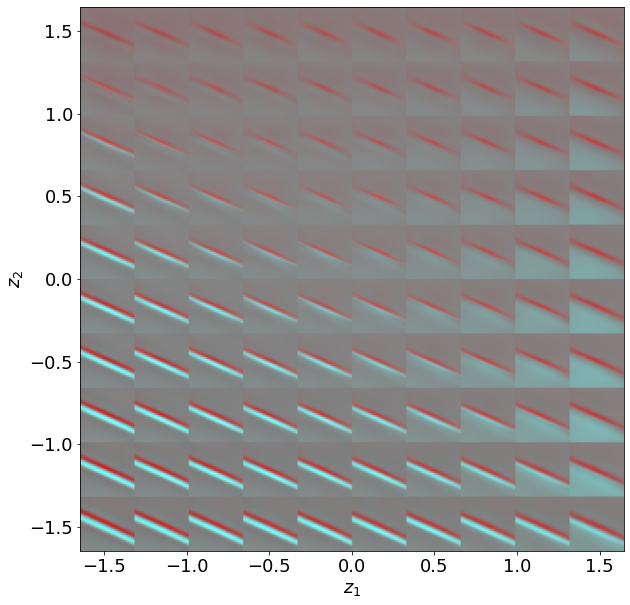

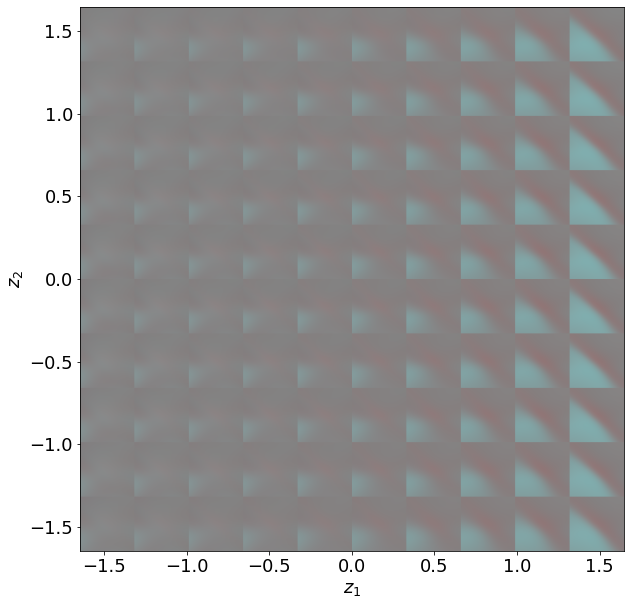

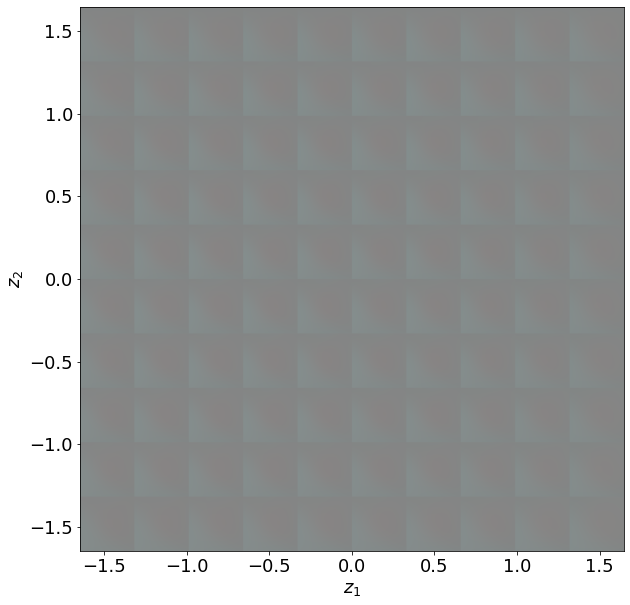

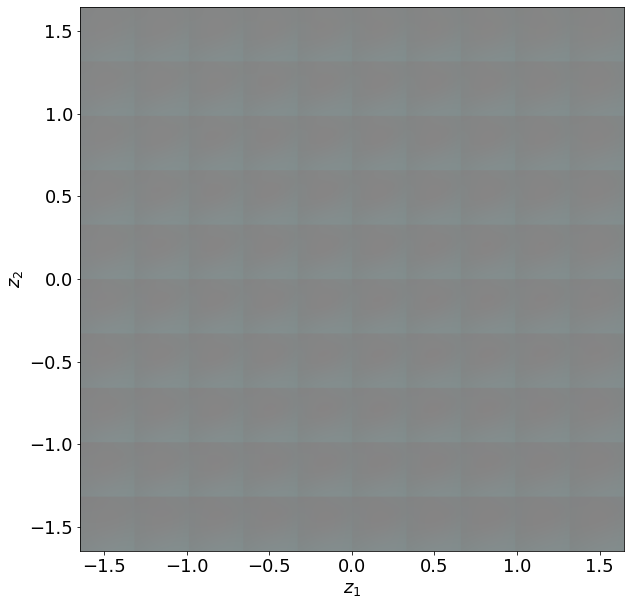

In [ ]:
#plot manifold2D of the rVAE models without time delay
for rvae_ in rvae_models:   
    rvae_.manifold2d(d=10)

*  Manifold2D of rVAE models with time delay

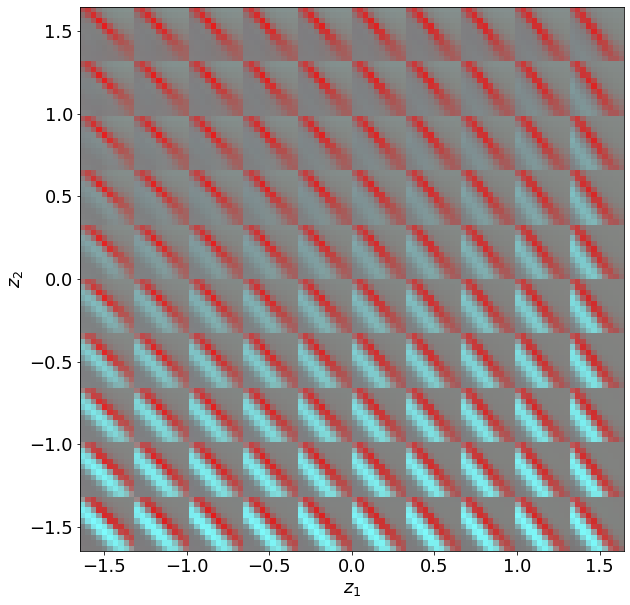

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


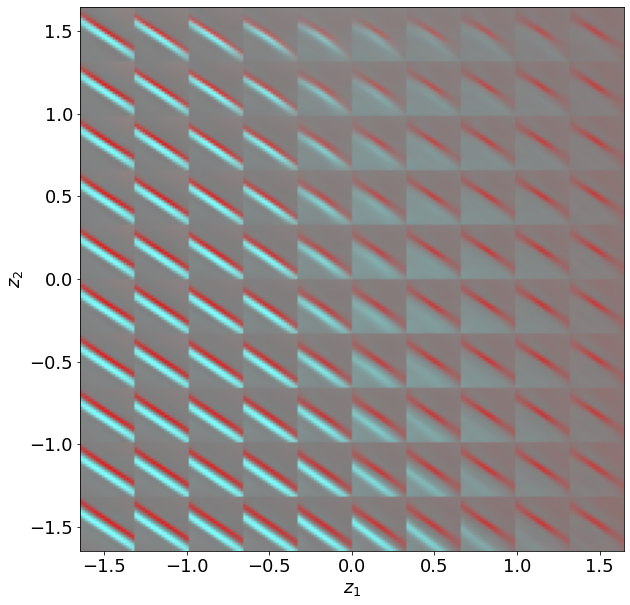

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


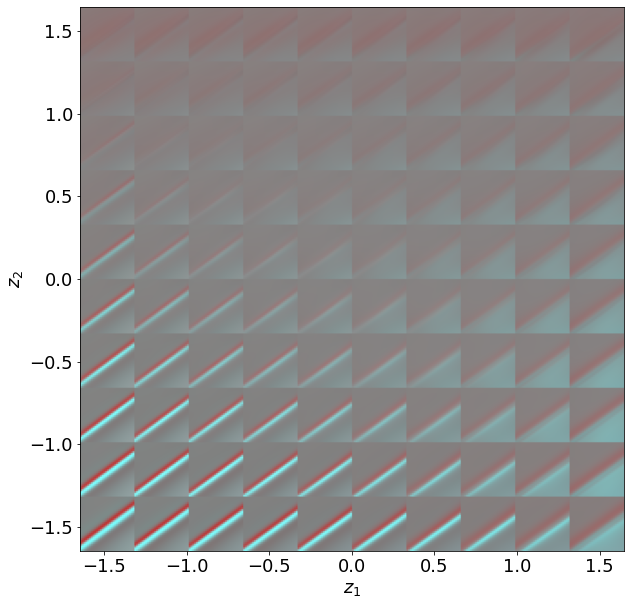

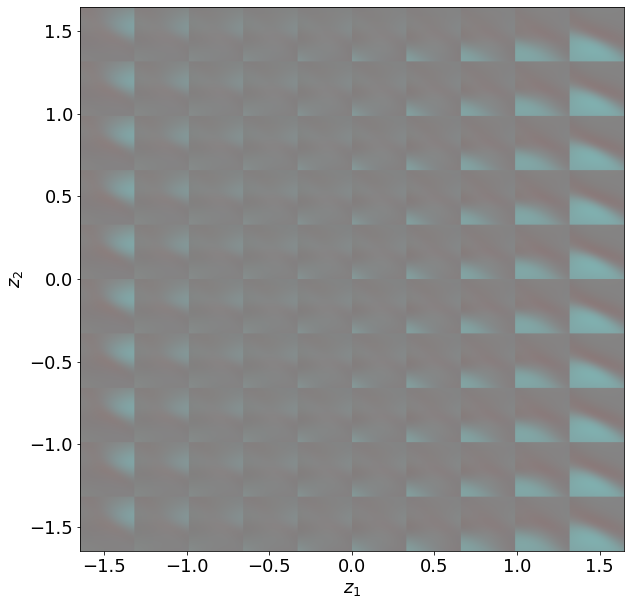

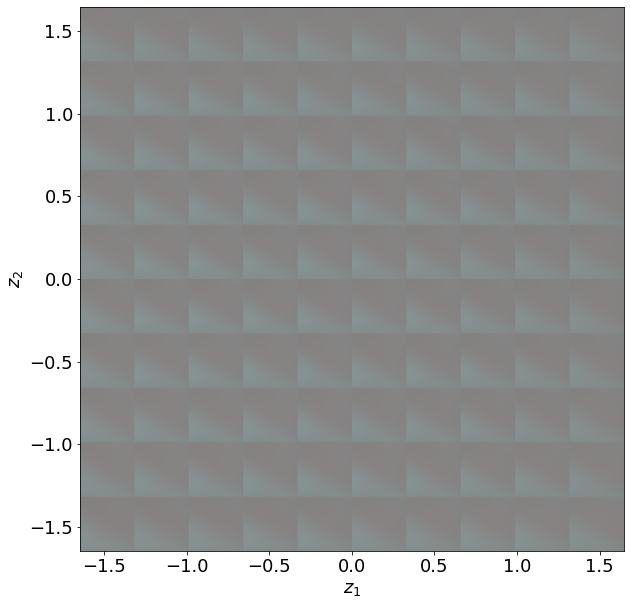

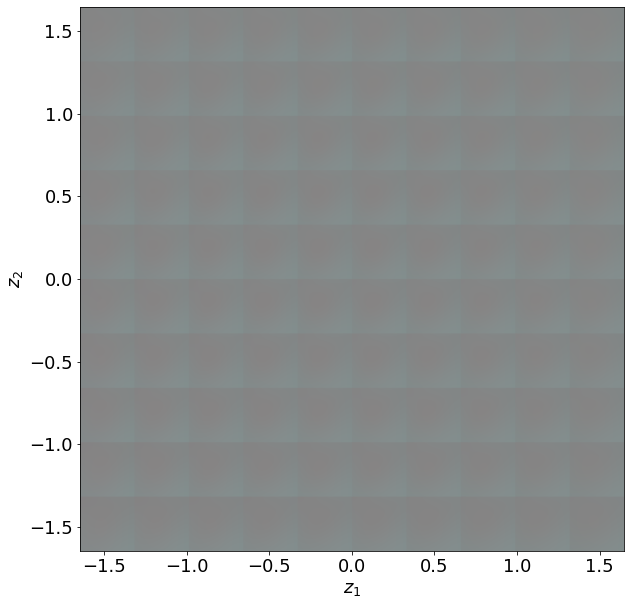

In [ ]:
#plot manifold2D of the rVAE models with time delay
for rvae_ in rvae_models_t: 
    rvae_.manifold2d(d=10)

### Explore pinning mechanism from latent space

Select the latent space for exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 299.5, -0.5)

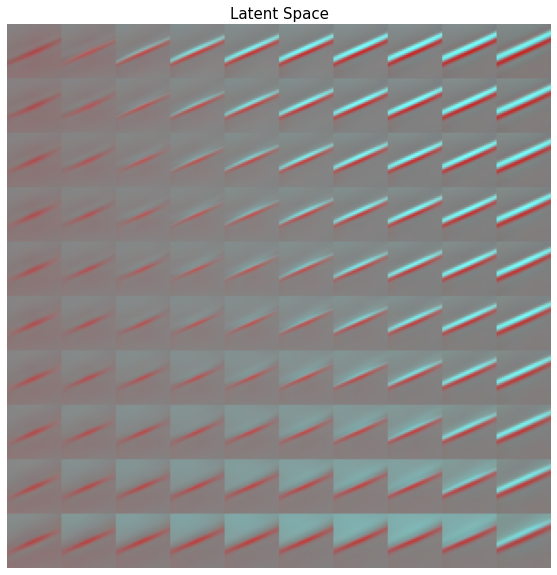

In [ ]:
rvae_ = rvae_30    #by assigning rvae_ with different models, readers can also explore the latent space of other models in the same manner
ws = 30
d = 10
grid_x = norm.ppf(np.linspace(0.05, 0.95, d))
grid_y = norm.ppf(np.linspace(0.05, 0.95, d))

figure = np.zeros((ws*d, ws*d,3))
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    imdec = rvae_.decode(z_sample)
    figure[i * ws: (i + 1) * ws, j * ws: (j + 1) * ws,:] = imdec
if figure.min() < 0:
  figure = (figure - figure.min()) / figure.ptp()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(figure, cmap='gnuplot')
ax.set_title('Latent Space', fontsize = 15)
ax.axis('off')

In [ ]:
#here, use a denser grid of latent space in order to explore more details

d = 200  # customize the grid number, here we use 200 
grid_x = norm.ppf(np.linspace(0.05, 0.95, d))
grid_y = norm.ppf(np.linspace(0.05, 0.95, d))

ws1 = 22
figure = np.zeros((ws1*d, ws1*d,3))
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    imdec = rvae_.decode(z_sample)
    im = ndimage.rotate(imdec[0,...],-25,mode='constant')  
    imdec= im[9:31,9:31,:]
    figure[i * ws1: (i + 1) * ws1, j * ws1: (j + 1) * ws1,:] = imdec
if figure.min() < 0:
  figure = (figure - figure.min()) / figure.ptp()

Extract the layer corresponding 180 wall and non-180 wall from the latent space

In [ ]:
#the latent space of three-layer dataset trained models is also three layer
f0 = figure [:,:,0]     #first layer corresponds to 180 walls
f1 = figure [:,:,1]     #second and third layer corresponds to non-180 walls

(-0.5, 49.5, 49.5, -0.5)

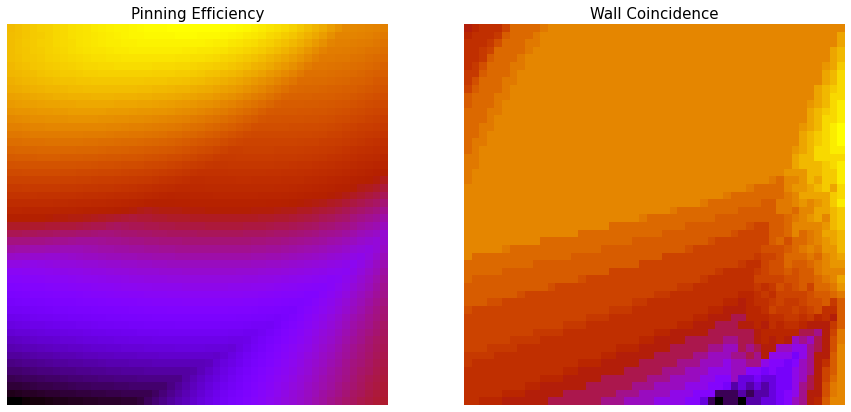

In [ ]:
# initialize arraies for saving pinnint efficiency and wall coincidence
fd = np.zeros((d,d))
fc = np.zeros((d,d))
r = np.zeros(22)
b = np.zeros(22)

#calculate pinning efficiency and wall coincidence
for i in range (d):
  for j in range (d):
    # the pinning efficiency is defined as the intensity of 180 walls in first layer
    fd[i,j] = f0[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1].max()- f0[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1].min()

    # the wall coincidence is defined as reciprocal of the average distance between 180 wall and non-180 wall
    hr = f0[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1]     # 180 wall sub-image in row i and column j of the latent space 
    hb = f1[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1]     # non-180 wall sub-image in row i and column j of the latent space
    for k in range (22):
      r[k] = np.argmax(hr[:,k])   # location of wall is define as the localtion with maximum wall intensity
      b[k] = np.argmax(hb[:,k])   # location of wall is define as the localtion with maximum wall intensity
     
    fc[i,j] = 1/((b-r).mean())    # calculate wall coincidence = reciprocal of average distance between 180 wall and non-180 wall

# plot the pinning efficiency and wall coincidence in the right-top corner of the latent space
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 7))
ax1.imshow(fd[:50,150:], cmap='gnuplot')
ax1.axis('off')
ax1.set_title('Pinning Efficiency', fontsize = 15)
ax2.imshow(fc[:50,150:], cmap = "gnuplot")
ax2.set_title('Wall Coincidence', fontsize = 15)
ax2.axis('off')

Text(0.5, 1.0, 'Asymmetric Gradient')

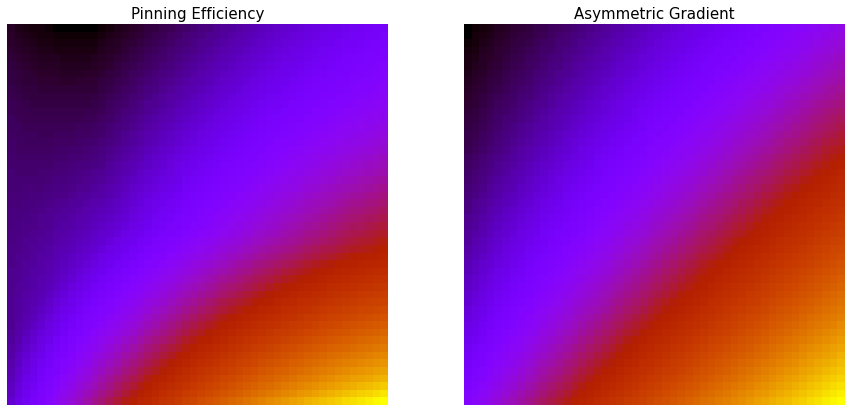

In [ ]:
# initialize arraies for saving pinnint efficiency and wall coincidence
fd = np.zeros((d,d))
fc = np.zeros((d,d))

#calculate pinning efficiency and asymmetric gradient
for i in range (d):
  for j in range (d):
    # the pinning efficiency is defined as the intensity of 180 walls in first layer
    fd[i,j] = f0[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1].max()- f0[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1].min()

    # the asymmetric gradient is define as the difference of non-180 wall intensity on the two sides of 180 wall
    f_sub = f1[i*ws1:(i+1)*ws1, j*ws1:(j+1)*ws1]        # 180 wall sub-image in row i and column j of the latent space
    fc[i,j] = f_sub[:5,:].mean()-f_sub[-5:,:].mean()    # calculate the difference of average non-180 wall intensity on the two sides of 180 wall

# plot pinning efficiency and asymmetric gradient in the bottom-left corner of latent space
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 7))
ax1.imshow(fd[150:,:50], cmap='gnuplot')
ax1.axis('off')
ax1.set_title('Pinning Efficiency', fontsize = 15)
ax2.imshow(fc[150:,:50], cmap = "gnuplot")
ax2.axis('off')
ax2.set_title('Asymmetric Gradient', fontsize = 15)

# Color domain wall image by latent variables


*   By coloring the image by latent variables, one can see the distribution of latent variables in the images



First, need to make a denser coordinate datasets

In [ ]:
#make denser coordinate dataset without time delay
wall_cor = ()

for i in range (37):
  index = np.where(imgstack2[i,...]==0.0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

dictionary = {}
for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*3,])):
    d = np.append(d,[[cor[j*3][i]], [cor[j*3+1][i]], [0]], axis =1)
    #d = np.append(d,[[cor[j*3][i]], [cor[j*3+1][i]], [cor[j*3+2][i]]], axis =1)
  d=d.T
  #control coordinates size to 1000
  A = np.arange(len(d))
  idx = np.random.choice(A, 1000, replace = False)
  B = d[idx,]
  dictionary [j] = np.array(B)

dense_coordinates_180 = dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
#make denser coordinate dataset with time delay t vs t+1
wi = imgstack2

dictionary = {}

wall_cor = ()
for i in range (37):
  index = np.where(wi[i,...]==0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*3,])):
    d = np.append(d,[[cor[j*3][i]], [cor[j*3+1][i]], [0]], axis =1)
  d=d.T
  #control coordinates size to 1000
  A = np.arange(len(d))
  idx = np.random.choice(A, 1000, replace = False)
  B = d[idx,]
  dictionary [j*2] = np.array(B)
  dictionary [j*2+1] = np.array(B)

dense_coordinates_180_t = dictionary

dense_coordinates_180_t.pop(73);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Then, color the image by latent variables

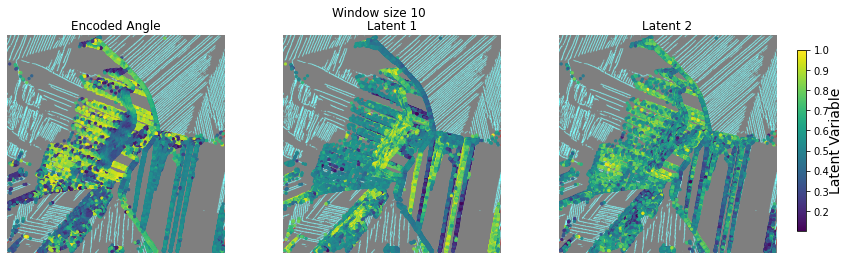

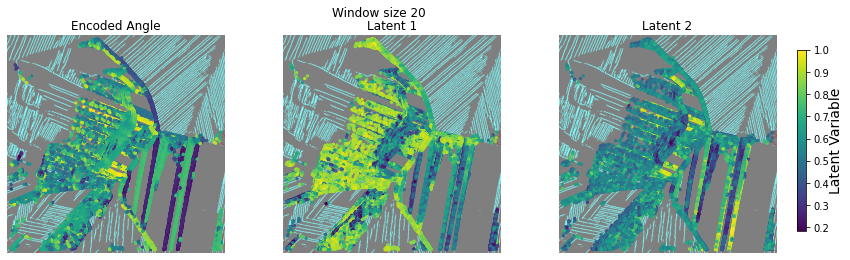

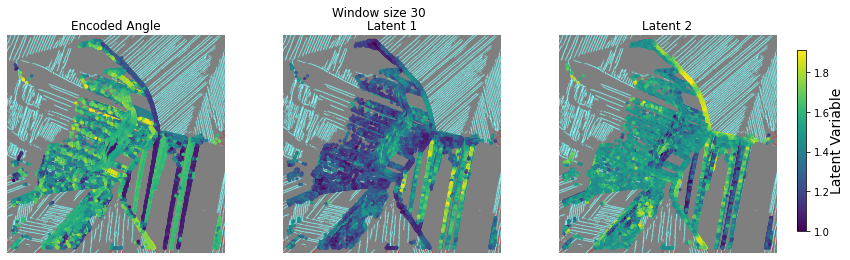

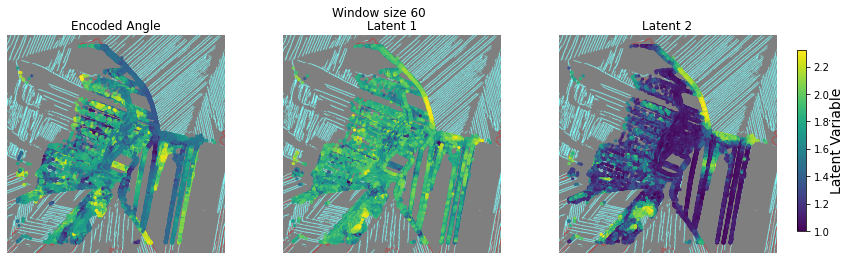

In [ ]:
# Plots of rvae models without time delay
r_models = rvae_models[:4] 
ws = [10, 20, 30, 60]   #Plot the latent variable distribution for models with window size < 60

for rvae_, ws in zip(r_models, ws):
  imstack, com, frames = utils.extract_subimages(imgstack2, dense_coordinates_180, window_size=ws)
  z_mean, z_sd = rvae_.encode(imstack)

  f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
  f.suptitle('Window size '+str(ws))
  ax1.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax1.set_title('Encoded Angle')
  ax2.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax2.set_title('Latent 1')
  ax3.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax3.set_title('Latent 2')

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')

#color by latent variables
  for i in range (37):
    coor = com[np.where(frames == i)]
    z = z_mean[np.where(frames == i)]
    ax1.scatter(coor[:,1], coor[:,0], c = z[:,0] , s = 5)
    ax2.scatter(coor[:,1], coor[:,0], c = z[:,1], s = 5)
    ax3.scatter(coor[:,1], coor[:,0], c = z[:,2], s = 5)
  
  clrbar = np.linspace(1, np.max(z[:,2])).reshape(-1, 1)
  ax_ = f.add_axes([.66, .2, .3, .63])
  img = plt.imshow(clrbar)
  plt.gca().set_visible(False)
  clrbar = plt.colorbar(ticks = None, orientation='vertical')
  clrbar.set_label('Latent Variable', fontsize=14, labelpad=0.1)
  plt.show()

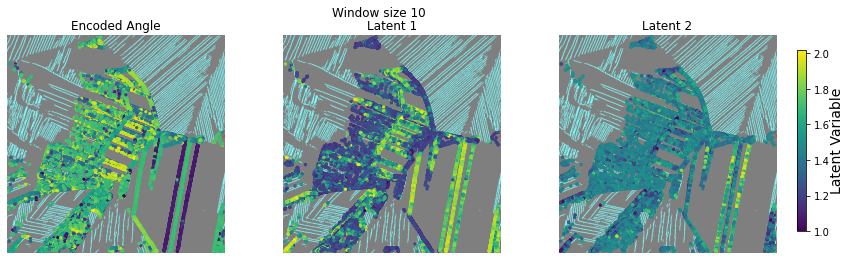

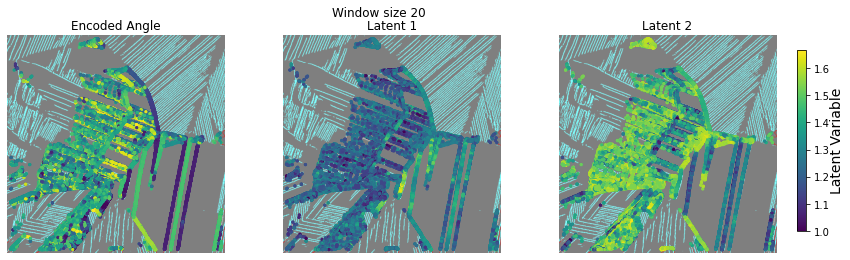

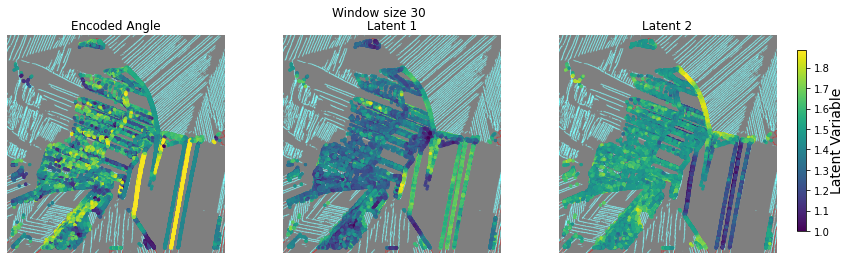

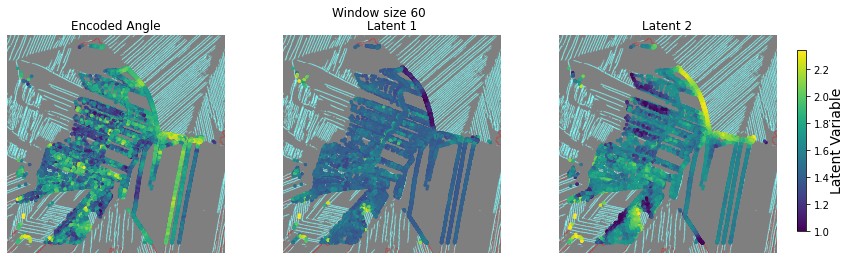

In [ ]:
# Plots of rvae models with time delay
r_models = rvae_models_t[:4] 
ws = [10, 20, 30, 60]  #Plot the latent variable distribution for models with window size < 60

for rvae_, ws in zip(r_models, ws):
  imstack, com, frames = utils.extract_subimages(imgstack_t, dense_coordinates_180_t, window_size=ws)
  z_mean, z_sd = rvae_.encode(imstack)

  f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
  f.suptitle('Window size '+str(ws))
  ax1.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax1.set_title('Encoded Angle')
  ax2.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax2.set_title('Latent 1')
  ax3.imshow(imgstack2[1,...], cmap = 'coolwarm')
  ax3.set_title('Latent 2')

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')

#color by latent variables
  for i in range (37):
    coor = com[np.where(frames == i)]
    z = z_mean[np.where(frames == i)]
    ax1.scatter(coor[:,1], coor[:,0], c = z[:,0] , s = 5)
    ax2.scatter(coor[:,1], coor[:,0], c = z[:,1], s = 5)
    ax3.scatter(coor[:,1], coor[:,0], c = z[:,2], s = 5)
  
  clrbar = np.linspace(1, np.max(z[:,2])).reshape(-1, 1)
  ax_ = f.add_axes([.66, .2, .3, .63])
  img = plt.imshow(clrbar)
  plt.gca().set_visible(False)
  clrbar = plt.colorbar(ticks = None, orientation='vertical')
  clrbar.set_label('Latent Variable', fontsize=14, labelpad=0.1)
  plt.show()